In [1]:
#Prophet model for time series forecast
from prophet import Prophet

#from ipywidgets.autonotebook import tqdm as notebook_tqdm



#Data processing
import numpy as np
import pandas as pd

#visualization
import seaborn as sns
import matplotlib.pyplot as plt

#Model performance evaluation
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score


In [2]:

#bcm = pd.read_csv(r"C:\Users\Parsazh\Documents\GitHub\Machine-Learning\data\BCM_DATA.csv",index_col=[0],parse_dates=[0])
bcm = pd.read_csv(r"..\data\BCM_DATA.csv",index_col=[0],parse_dates=[0])
#bcm = bcm.loc[bcm['FISCAL_YEAR'] >= 2015].copy()


In [3]:
train_end_date = pd.to_datetime('2024-03-31')

bcm_train = bcm.loc[bcm.index <= train_end_date].copy()
bcm_test = bcm.loc[bcm.index > train_end_date].copy()

#print(bcm_train.tail())

# Format data for prophet model using ds and y
bcm_train_prophet = bcm_train["TOT_PAID"].reset_index().rename(columns={'ACC_MONTH':'ds','TOT_PAID':'y'})
bcm_test_prophet = bcm_test["TOT_PAID"].reset_index().rename(columns={'ACC_MONTH':'ds','TOT_PAID':'y'})
#print(bcm_train_prophet.head())


In [4]:
#Repeat the selected model with the most recent data and forecast the next fiscal year's expense

train_end_date = pd.to_datetime('2024-03-31')

bcm_train = bcm.loc[bcm.index <= train_end_date].copy()
bcm_test = bcm.loc[bcm.index > train_end_date].copy()


# 3- model fit: including Seasonal effect and Regression

# prep dataset to includes forcasting factor (y) and regressrs

multi_train = bcm_train[["TOT_PAID","BUDGET_AMT","NBR_MURDER"]].reset_index().rename(columns={'ACC_MONTH':'ds'
                                                                                                  ,'TOT_PAID':'y'
                                                                                                  ,'BUDGET_AMT':'bud'
                                                                                                  ,'NBR_MURDER':'case'})
multi_test  =  bcm_test[["TOT_PAID","BUDGET_AMT","NBR_MURDER"]].reset_index().rename(columns={'ACC_MONTH':'ds'
                                                                                       ,'TOT_PAID':'y'
                                                                                       ,'BUDGET_AMT':'bud'
                                                                                       ,'NBR_MURDER':'case'})



multi_total = bcm[["TOT_PAID","BUDGET_AMT","NBR_MURDER"]].reset_index().rename(columns={'ACC_MONTH':'ds'
                                                                                                  ,'TOT_PAID':'y'
                                                                                                  ,'BUDGET_AMT':'bud'
                                                                                                  ,'NBR_MURDER':'case'})

# Add seasonality 
model_final = Prophet(yearly_seasonality=True)


# Add regressor
model_final.add_regressor('bud', standardize=True)
model_final.add_regressor('case', standardize=False)

# Fit the model on the training dataset
model_final.fit(multi_total)
multi_train_prdct = model_final.predict(multi_total)


14:55:28 - cmdstanpy - INFO - Chain [1] start processing
14:55:28 - cmdstanpy - INFO - Chain [1] done processing


14:55:45 - cmdstanpy - INFO - Chain [1] start processing
14:55:45 - cmdstanpy - INFO - Chain [1] done processing
14:55:46 - cmdstanpy - INFO - Chain [1] start processing
14:55:46 - cmdstanpy - INFO - Chain [1] done processing


Text(0, 0.5, 'Case Managers Budget')

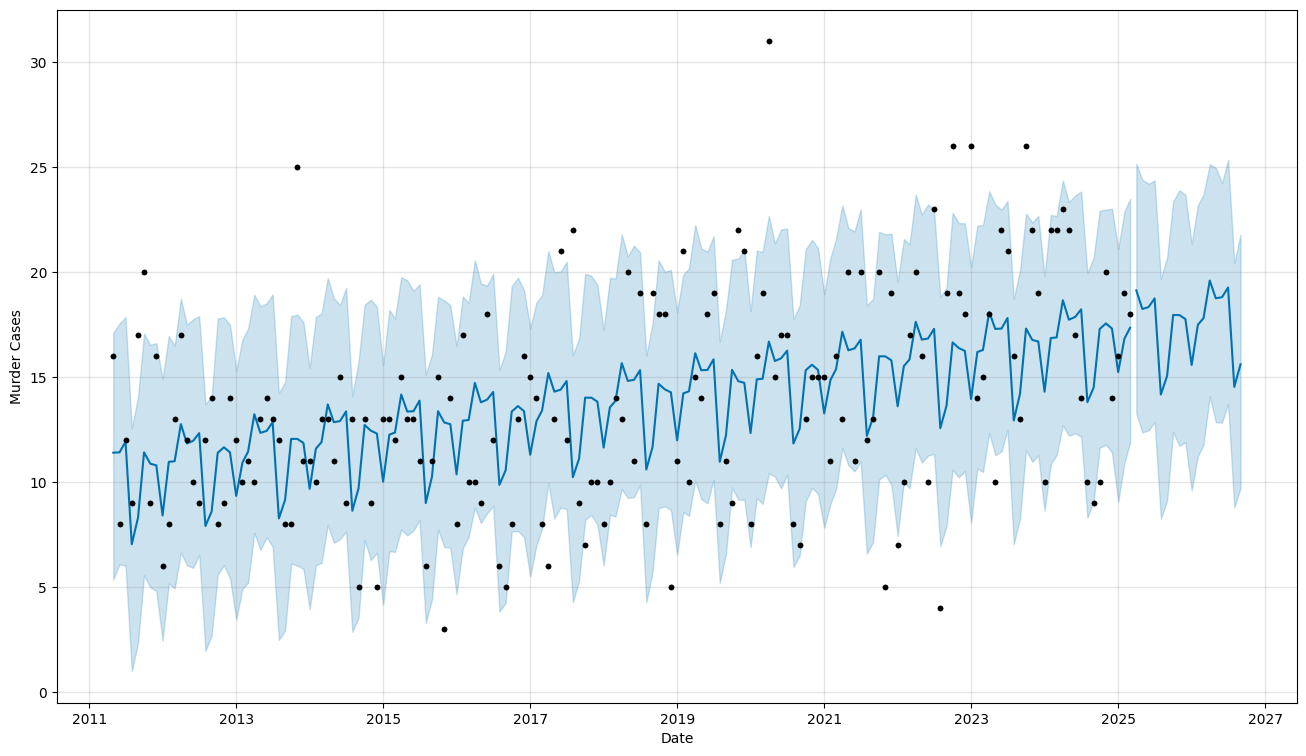

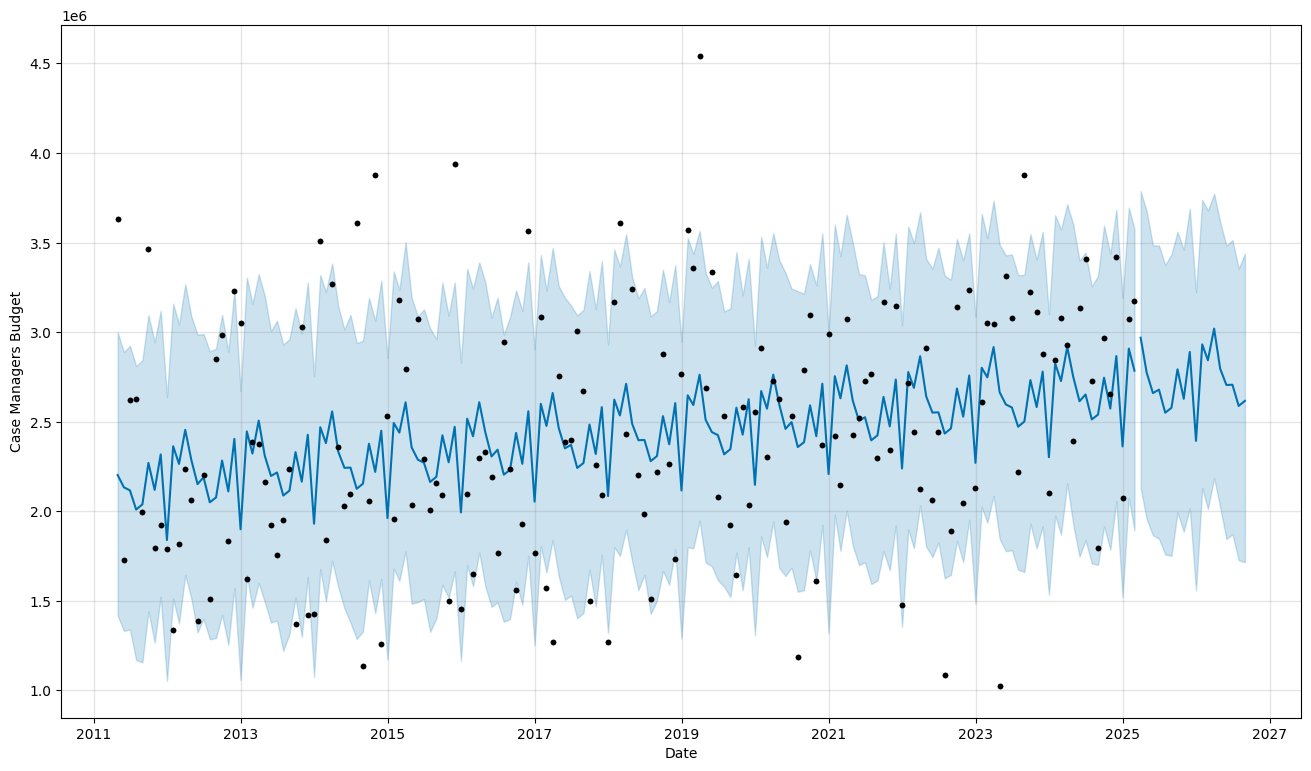

In [6]:

#forecsst the 1st regressor
#########################################################################################
train_case_p = multi_total[["ds","case"]].rename(columns={"case":"y"})
#test_case_p = multi_train[["ds","case"]].rename(columns={"case":"y"})
model_case = Prophet(yearly_seasonality=True)
model_case.fit(train_case_p)
train_case_prdct = model_case.predict(train_case_p)
#test_case_prdct = model_case.predict(test_case_p)
case_future = model_case.make_future_dataframe(periods=18,freq='ME',include_history=False)
case_future_prdct = model_case.predict(case_future)

f, ax = plt.subplots(figsize=(16,9))
plot1 = model_case.plot(train_case_prdct, ax=ax);
plot1 = model_case.plot(case_future_prdct, ax=ax);
ax.set_xlabel('Date')
ax.set_ylabel('Murder Cases')


#########################################################################################
#forecsst the 2nd regressor
#########################################################################################
train_bud_p = multi_total[["ds","bud"]].rename(columns={"bud":"y"})
model_bud = Prophet(yearly_seasonality=True)
model_bud.fit(train_bud_p)
train_bud_prdct = model_bud.predict(train_bud_p)

#set the forecasting length
bud_future = model_bud.make_future_dataframe(periods=18,freq='ME',include_history=False)
bud_future_prdct = model_bud.predict(bud_future)

#ploting both trend and forecast in one graph
f, ax = plt.subplots(figsize=(16,9))
plot1 = model_bud.plot(train_bud_prdct , ax=ax);
plot1 = model_bud.plot(bud_future_prdct, ax = ax);
ax.set_xlabel('Date')
ax.set_ylabel('Case Managers Budget')




Text(0.5, 1.0, 'BCM Expenditures: Actual, Prediction and Forecast')

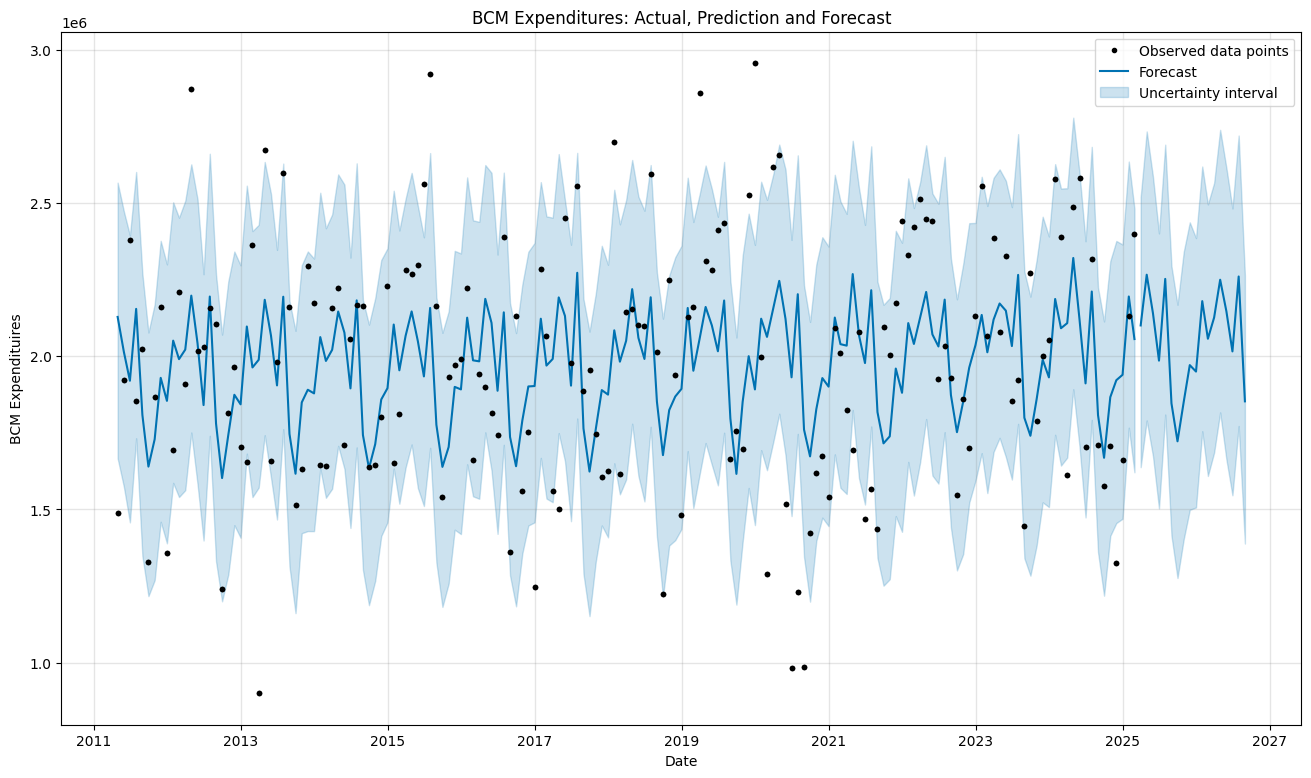

In [9]:
mulit_future = model_final.make_future_dataframe(periods = 18, freq='ME', include_history=True)

mulit_future['case'] = multi_total['case']
mulit_future['bud'] = multi_total['bud']

#Prep the regressors for forecasting the Actual Expense
case_future_prdc_2 = case_future_prdct[['ds','yhat']].rename(columns={"yhat":"yhat_case"})
bud_future_prdc_2 = bud_future_prdct[['ds','yhat']].rename(columns={"yhat":"yhat_bud"})

df_merge = pd.merge(case_future_prdc_2,bud_future_prdc_2,on='ds')

multi_future = pd.merge(df_merge,mulit_future,on='ds')

multi_future.fillna({'case':multi_future['yhat_case'],
                   'bud' :multi_future['yhat_bud']},inplace=True)
multi_future.drop(['yhat_case','yhat_bud'],inplace=True, axis=1)

mulit_future_prdct = model_final.predict(multi_future)

f, ax = plt.subplots(figsize=(16,9))
plot1 = model_final.plot(multi_train_prdct,ax=ax)
plt.legend()
plot2 = model_final.plot(mulit_future_prdct,ax=ax)

#plot3 = plt.plot(bcm_train_prophet['ds'],bcm_train['TOT_PAID'],color='r')
#plt.plot(multi_train_prdct['ds'],multi_train_prdct['yhat'],color='r')

ax.set_xlabel("Date")
ax.set_ylabel("BCM Expendituires")
ax.set_title("BCM Expenditures: Actual, Prediction and Forecast")



In [10]:
print(mulit_future_prdct[['ds','yhat']].tail(20))

           ds          yhat
0  2025-03-31  2.100333e+06
1  2025-04-30  2.265813e+06
2  2025-05-31  2.140244e+06
3  2025-06-30  1.985482e+06
4  2025-07-31  2.252155e+06
5  2025-08-31  1.845988e+06
6  2025-09-30  1.722251e+06
7  2025-10-31  1.851162e+06
8  2025-11-30  1.970862e+06
9  2025-12-31  1.949771e+06
10 2026-01-31  2.179639e+06
11 2026-02-28  2.056853e+06
12 2026-03-31  2.126152e+06
13 2026-04-30  2.249505e+06
14 2026-05-31  2.146252e+06
15 2026-06-30  2.015574e+06
16 2026-07-31  2.260026e+06
17 2026-08-31  1.852649e+06


In [32]:
# fig, ax = plt.subplots(figsize=(10, 5))
# fig = model.plot(bcm_test_fcst, ax=ax, xlabel='Date', ylabel='Total Paid')
# ax.plot(bcm_train.index, bcm_train['TOT_PAID'], color='b')

# ax.set_title('Prophet Forecast')


# #fig = model.plot_components(bcm_test_fcst)

# plt.show()




In [33]:

# #plot one fiscal year

# lower_bound = pd.to_datetime('2024-04-30')  # Ensure correct format
# upper_bound = pd.to_datetime('2025-04-30')

# fig, ax = plt.subplots(figsize=(10, 5))

# ax.plot(bcm_test.index, bcm_test['TOT_PAID'], color='r')
# fig = model.plot(bcm_test_fcst, ax=ax)
# # Set x-axis limits with datetime values
# ax.set_xbound(lower=lower_bound, upper=upper_bound)
# #ax.set_ylim(0, 60000)
# plot = plt.suptitle('Forecast vs Actuals - fiscal year 2024-25')
# plt.show()


In [34]:
# #plot the forecast with the actual ternd in trained dataset

# # Plot the forecast with the actuals

# lower_bound = pd.to_datetime('2015-04-30')  # Ensure correct format
# upper_bound = pd.to_datetime('2024-03-31')

# f, ax = plt.subplots(figsize=(15, 5))
# ax.plot(bcm_train.index, bcm_train['TOT_PAID'], color='r')
# fig = model.plot(bcm_train_fcst, ax=ax)
# ax.set_xbound(lower=lower_bound, upper=upper_bound)
# # Add legend
# ax.legend(['Actual TOT_PAID', 'Forecasted TOT_PAID'])
# ax.set_title('Forecast vs Actuals - Basemodel Simulation')
# #plt.show()



In [35]:
# # Create the time range for the forecast
# future_fcst = model.make_future_dataframe(periods=18,freq='ME',include_history=True)
# print(future_fcst.tail(20))

# # Make prediction
# forecast_baseline = model.predict(future_fcst)
# #print(forecast_baseline.tail(20))
# # Visualize the forecast
# model.plot(forecast_baseline); # Add semi-colon to remove the duplicated chart

# # Visualize the forecast components
# #model.plot_components(forecast_baseline)

# #plt.show()
# #check the model's accuracy

# mean_squared_error_b = np.sqrt(mean_squared_error(y_true=bcm_test['TOT_PAID'],
#                    y_pred=bcm_test_fcst['yhat']))
# print(mean_squared_error_b)

In [36]:
# # plot Prediction vs Actual in Test period
# plt.figure(figsize=(20, 10))
# plt.plot(multi_test_prdct['ds'],multi_test_prdct['yhat'])
# plt.plot(multi_test['ds'],multi_test['y'])
# plt.xticks(rotation='vertical')
# plt.grid(True)
# plt.show()

In [37]:
# # plot Prediction vs Actual in train period
# plt.figure(figsize=(20, 10))

# plt.plot(bcm_train_prophet['ds'],bcm_train['TOT_PAID'],color='b')
# plt.plot(multi_train_prdct['ds'],multi_train_prdct['yhat'],color='r')
# plt.xticks(rotation='vertical')
# plt.grid(True)
# plt.show()